In this homework, you will write a python implementation of a neural network with one hidden layer for the binary classification. Your network takes an n-dimensional data point and produces a scalar z to be used for binary classification.

You will test it on the half moon dataset.

The sections marked **NEW** are the new functions you need to fill in.

First we import some libraries as before.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

We define some functions involved. Use the formulations that avoid overflows.  
1. sigmoid function sigmoid(t)
2. log of sigmoid(t), called log_sig(t)
3. log of 1-sigmoid = 1/(1+e^t), called log_one_sig(t)
4. cross-entropy loss function given the inputs of label y and prediction y_hat = sigmoid(z), where y, y_hat, and z are vectors of dimension N. (N = # of data points.) You should implement this function with z, rather than y_hat, as the input; namely, the loss function should be

    loss = -y log(sigmoid(z)) - (1-y) log (1-sigmoid(z))

  where log(sigmoid(z)) and log (1-sigmoid(z)) should be computed by the functions log_sig(z) and log_one_sig(z) in parts 2 and 3.

In [2]:
def sigmoid(t):
    return 1.0/(1 + np.exp(-t))

def loss(y, z):
    # compute loss(y, sigmoid(z))
    # y --> label
    # z --> model output

    loss = np.mean(-y*(mylog(z)) - (1-y)*mylogminus(z))
    return loss

def mylog(t):
    # compute log(sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = t[i]-np.log(1+np.exp(t[i]))
      else:
        y[i] = -np.log(1+np.exp(-t[i]))

    return y

def mylogminus(t):
    # compute log(1-sigmoid(t)) to be used in loss

    y = 0*t
    m=t.shape[0]
    for i in range(m):
      if t[i] < 0:
        y[i] = -np.log(1+np.exp(t[i]))
      else:
        y[i] = -t[i]- np.log(1+np.exp(-t[i]))

    return y


 **New:**
 We define the ReLU function and its derivative ReLUprime

In [3]:
def ReLU(t):
  return np.maximum(0, t)

def ReLUprime(t):
  # derivative of ReLU
  return np.where(t < 0, 0, 1)

**New:** Define the neural network function with one hidden layer. Your function should take the data matrix X (N-by-n matrix) containing N input points and produce a vector of dimension N containing N output values, one for each data point for the binary classification. The function should also take as inputs the model parameters:

output layer: w (n-dimensional weigth vector), b (bias),

hidden layer: W_one (n_one-by-n matrix), and b_one (n_one dimensional vector).

Use ReLU as the nonlinear activation function.

In [4]:
from sklearn.datasets import make_moons
X_train, y_train = make_moons(n_samples=500, noise=0.1) # N samples (500 for train) x 2 features
X_test, y_test = make_moons(n_samples=1000, noise=0.1)

In [5]:
def model(w, b, W_one, b_one, X):

    # X --> N-by-n Input. 500 points x 2 features
    # z --> model output. 500 point vector
    # w --> output layer weight. 150 neuron vector
    # b --> output layer bias. scalar
    # W_one --> hidden layer weight. 150 neurons x 2 features
    # b_one --> hidden layer bias. 150 neurons x 500 points

    # hidden layer
    a_one = np.matmul(W_one, X.T) + b_one[:, np.newaxis] # a_one: 150 neurons x 500 points

    # ^ b_one is added to every column ^
    h_one = ReLU(a_one) # h_one: 150 neurons x 500 points

    # output layer
    z = (np.matmul(w.reshape(1, 150), h_one) + b).flatten() # z: 500 point vector

    return z, a_one, h_one # N-vector

**New:** Define the function that generates the output of the neural network and the gradient of the cross-entropy loss using the forward and backward propagation algorithms. The forward propagation should be the same as your *model(w, b, W_one, b_one, X)*.

Your function should take the data matrix X (N-by-n matrix), the label y (N-vector), and the model parameters (w, b, W_one, b_one) as inputs and produces network output z, the gradients dw, db, dW_one, db_one as outputs.

In [6]:
def gradients(w, b, W_one, b_one, X, y):

    # X --> N-by-n Input. 500 x 2
    # z --> model output. 500 x 1
    # w --> output layer weight. 150 x 1
    # b --> output layer bias.
    # W_one --> hidden layer weight. 150 x 2
    # b_one --> hidden layer bias. 150 x 1
    # y --> 500 x 1

    z, a_one, h_one = model(w, b, W_one, b_one, X)
    # a_one: 150 x 500
    # h_one: 150 x 500
    # z: 500 vector

    # dL/dz
    dLdz = sigmoid(z) - y # N-vector. 500 x 1

    # dL/dW
    dw = np.dot(dLdz.T, h_one.T)/500 # Should result in a 150x1 vector

    # dL/db
    db = np.sum(dLdz)/500 # mean of dLdz

    # dL/dh_one
    dLdz = dLdz.reshape(-1, 1)
    w = w.reshape(1, -1)
    dLdh_one = np.matmul(dLdz, w) # should be 150x500

    # dL/da_one
    a_oneReLUprime = ReLUprime(a_one)
    dLda_one = dLdh_one * a_oneReLUprime.T

    # dL/db_one
    db_one = np.sum(dLda_one, axis=0)

    # dL/dW_one
    dW_one = np.dot(dLda_one.T, X)

    return z, dw, db, dW_one, db_one

**New:** Write the function that train the neural network by the gradient descent algorithm using a fixed number of iteration (*iter*) and learning rate (*lr*). Your function should take *iter* and *lr* as well as the initial parameters, the input data X and the label y as the inputs. It produces new parameters as output. Also compute the loss value at each iteration and output the sequence of the loss.

This code should be basically the same as your *train()* function before. The only difference is that you do not need to call the *model()* function, as the model output should have been computed as part of the *gradient()* function output.

In [7]:
def train(w, b, W_one, b_one, X, y, iter, lr):

    # X --> N-by-n Input.
    # z --> model output.
    # w --> output layer weight.
    # b --> output layer bias.
    # W_one --> hidden layer weight.
    # b_one --> hidden layer bias.
    # iter --> number of iterations
    # lr --> Learning rate.

    # N-> number of training examples
    # n-> number of features
    N, n = X.shape

    z, a_one, h_one = model(w, b, W_one, b_one, X)
    y_hat = sigmoid(z)

    # empty list to store losses
    losses = list()

    # training loop
    for i in range(iter):
      z, dw, db, dW_one, db_one = gradients(w, b, W_one, b_one, X, y)
      w -= lr * dw
      b -= lr * db
      W_one -= lr * dW_one
      b_one -= lr * db_one
      l = loss(y, z)
      losses.append(l)
      print('Iteration ', i+1, 'accuracy = ', accuracy(np.squeeze(y),  predict(z)), 'loss = ', l)

    return w, b, W_one, b_one, losses



As before,

1. *predict()* produces class prediction label y_label (N-vector of 0 or 1) given the model output z.

2. *accuracy()* computes the accuracy of prediction.



In [8]:
def predict(output):

    # output --> model output
    # pred_class --> model class prediction

    # Empty List to store predictions.
    pred_class = []
    # if z >= 0 --> 1
    # if z < 0 --> 0
    pred_class = [1 if i > 0 else 0 for i in output]

    return np.array(pred_class)

def accuracy(y, y_predict):
    accuracy = np.sum(y == y_predict) / len(y)
    return accuracy


**New:** We test the code on the half moon dataset. The code below  uses l_one = 150 neurons in the hidden layer and the weights are initialized to be the stadard random normal distribution N(0,1). You should also try the Xavier Glorot and Kaiming He initializations. You should try at least 4 learning rates. Your best accuracy should well exceed 95% with a loss below 0.1.

Iteration  1 accuracy =  0.122 loss =  8.795542492422408
Iteration  2 accuracy =  0.792 loss =  101.88109294119361
Iteration  3 accuracy =  0.826 loss =  61.040624156447436
Iteration  4 accuracy =  0.824 loss =  51.29616378222604
Iteration  5 accuracy =  0.864 loss =  28.466782769902718
Iteration  6 accuracy =  0.856 loss =  21.63057008654068
Iteration  7 accuracy =  0.878 loss =  13.014953768608542
Iteration  8 accuracy =  0.884 loss =  11.213274147748406
Iteration  9 accuracy =  0.892 loss =  6.916264555803061
Iteration  10 accuracy =  0.892 loss =  8.250582267224692


<ipython-input-2-645d45dd9c37>:2: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-t))


Iteration  11 accuracy =  0.874 loss =  9.419452351131714
Iteration  12 accuracy =  0.86 loss =  13.48643375364181
Iteration  13 accuracy =  0.852 loss =  11.953857253344605
Iteration  14 accuracy =  0.88 loss =  10.952697999957563
Iteration  15 accuracy =  0.908 loss =  3.718984237516989
Iteration  16 accuracy =  0.946 loss =  1.7731682495915524
Iteration  17 accuracy =  0.966 loss =  0.7725414204502392
Iteration  18 accuracy =  0.974 loss =  0.5272933706662956
Iteration  19 accuracy =  0.976 loss =  0.42630494037879735
Iteration  20 accuracy =  0.98 loss =  0.3551390851189942
Iteration  21 accuracy =  0.982 loss =  0.3015336729852875
Iteration  22 accuracy =  0.982 loss =  0.2569697631960844
Iteration  23 accuracy =  0.984 loss =  0.21836344147529838
Iteration  24 accuracy =  0.984 loss =  0.1835968238136906
Iteration  25 accuracy =  0.984 loss =  0.15192498120558617
Iteration  26 accuracy =  0.984 loss =  0.12412651396249688
Iteration  27 accuracy =  0.988 loss =  0.1006152301393014

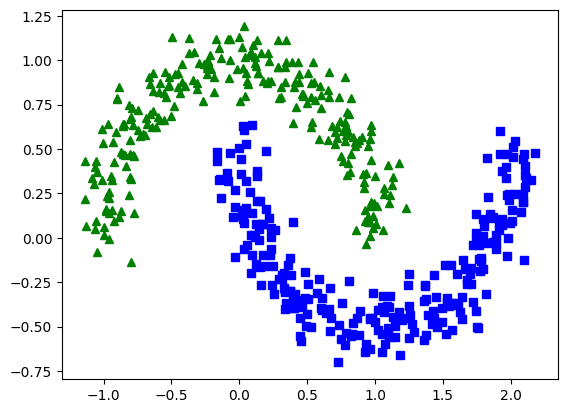

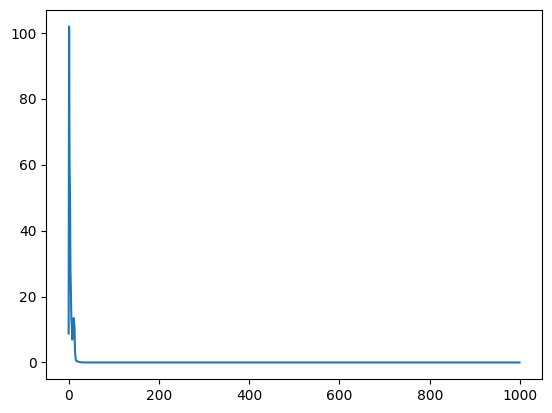

In [9]:
from sklearn.datasets import make_moons
X_train, y_train = make_moons(n_samples=500, noise=0.1)
X_test, y_test = make_moons(n_samples=1000, noise=0.1)

plt.figure()
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "g^")
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs")

# initialization
l_one=150
n=X_train.shape[1]
w=np.random.randn(l_one)
b = 0
W_one = np.random.randn(l_one, X_train.shape[1])
b_one = 0*np.random.rand(l_one)

# train
w, b, W_one, b_one, losses = train(w, b, W_one, b_one, X_train, y_train, iter=1000, lr=0.1)

# print results
plt.figure()
plt.plot(losses)

#training accuracy
z = model(w,b,W_one, b_one,X_train)[0]
acc = accuracy(np.squeeze(y_train), predict(np.squeeze(z)))
print(acc)

# testing accuracy
z = model(w,b,W_one, b_one,X_test)[0]
acc = accuracy(np.squeeze(y_test), predict(np.squeeze(z)))

print(acc)